# Image Generation

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/jiegg/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [3]:
limit_mem()

In [4]:
path = "/home/jiegg/open/data/imagenet-sample-train/train/"

In [5]:
fnames = glob.glob(path+"**/*.JPEG",recursive=True) #返回所有匹配的文件路径列表

In [6]:
fnames[1]

'/home/jiegg/open/data/imagenet-sample-train/train/n02445715/n02445715_11166.JPEG'

In [7]:
fn = fnames[100];fn

'/home/jiegg/open/data/imagenet-sample-train/train/n02074367/n02074367_3731.JPEG'

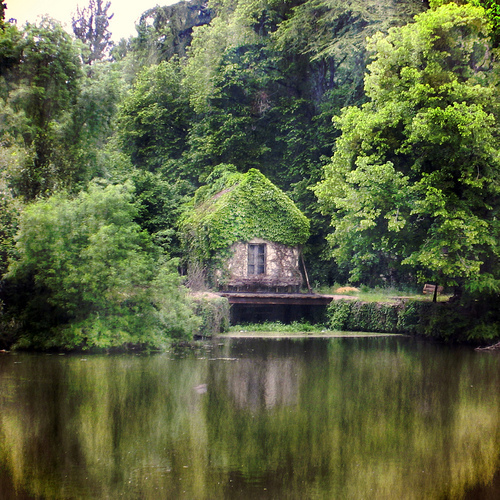

In [8]:
img=Image.open(fnames[956]);img

In [9]:
rn_mean = np.array([123.68,116.779,103.939],dtype=np.float32)
preproc = lambda x:(x-rn_mean)[:,:,:,::-1]

In [10]:
deproc = lambda x,s:np.clip(x.reshape(s)[:,:,:,::-1]+rn_mean,0,255)

### 上面定义两函数，分别对图形进行相应变换以适合VGG16 

In [11]:
img_arr = preproc(np.expand_dims(np.array(img),0)) #增加一个维度，并对输入图像进行变换
shp = img_arr.shape

In [12]:
shp

(1, 500, 500, 3)

In [13]:
np.array(img).shape

(500, 500, 3)

## Broadcasting exp

In [14]:
np.array([1,2,3])-2

array([-1,  0,  1])

In [15]:
np.array([2,3]).reshape(1,1,1,2)

array([[[[2, 3]]]])

## Recreate input

In [16]:
model = VGG16_Avg(include_top = False)

In [17]:
layer = model.get_layer("block5_conv1").output

In [18]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [19]:
model.input

<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>

In [20]:
class Evaluator(object):
    def __init__(self,f,shp): self.f, self.shp=f,shp
        
    def loss(self,x):
        loss_,self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [21]:
loss = metrics.mse(layer,targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input],[loss]+grads)
evaluator = Evaluator(fn, shp)

In [22]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

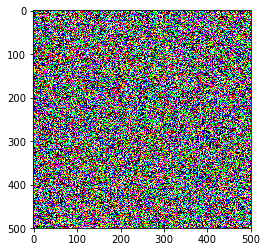

In [23]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [24]:
iterations=1
x = solve_image(evaluator, iterations, x)

Current loss value: 30.823266983


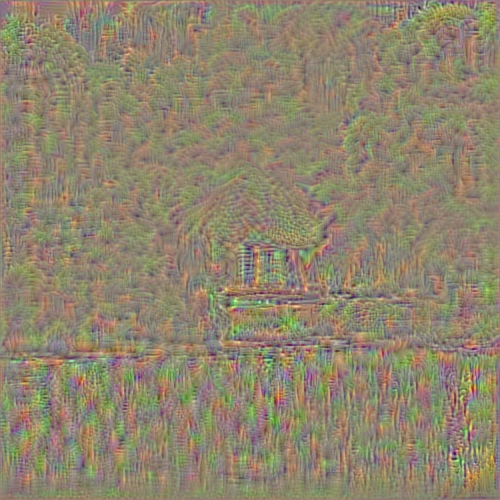

In [25]:
Image.open(path + 'results/res_at_iteration_0.png')

### creat style

In [26]:
def plot_arr(arr):plt.imshow(deproc(arr,arr.shape)[0].astype("uint8"))

In [57]:
style = Image.open("/home/jiegg/open/data/imagenet-sample-train/starry_night.jpg")

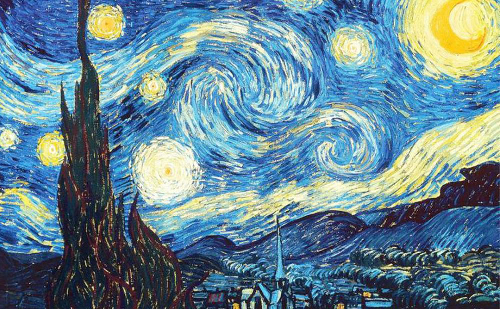

In [58]:
style = style.resize(np.divide(style.size,2).astype("int32"));style

In [63]:
style.size

(500, 309)

In [61]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])

In [71]:
shp = style_arr.shape;shp

(1, 309, 500, 3)

In [72]:
shp

(1, 309, 500, 3)

In [73]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

In [74]:
layers = [outputs["block{}_conv1".format(o)] for o in range(1,3)]

In [35]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [36]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [37]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [38]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [39]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

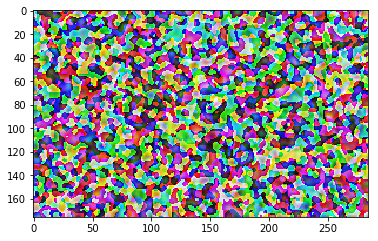

In [40]:
plt.imshow(x[0]);

In [41]:
iterations=1
x = rand_img(shp)

In [42]:
x = solve_image(evaluator, iterations, x)

Current loss value: 11166.328125


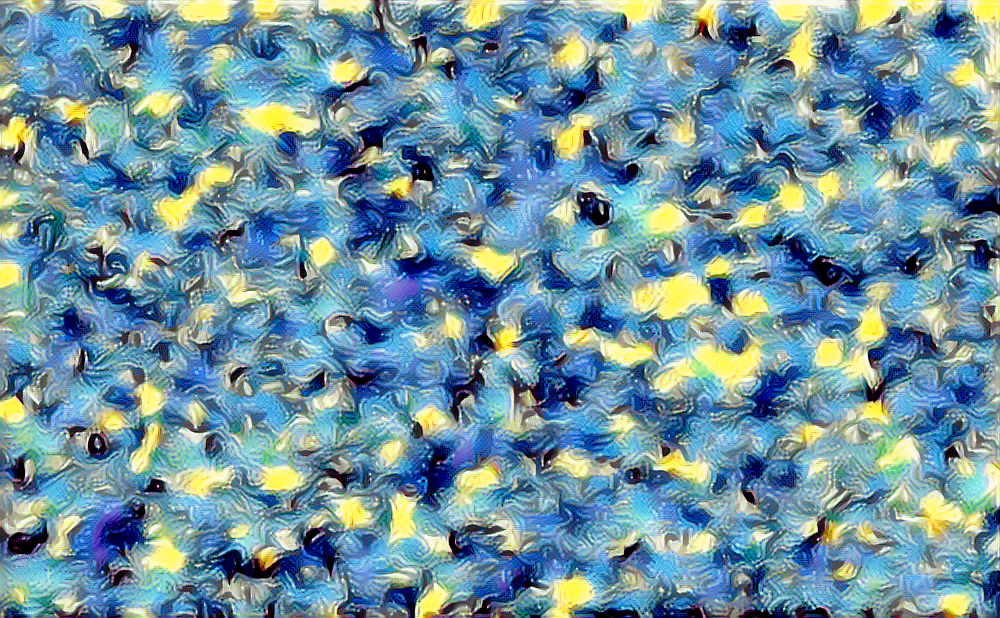

In [43]:
Image.open(path + 'results/res_at_iteration_1.png')

## style transfer

In [65]:
w,h = style.size#将style size 套入contant
src = img_arr[:,:h,:w]
src.shape

(1, 309, 500, 3)

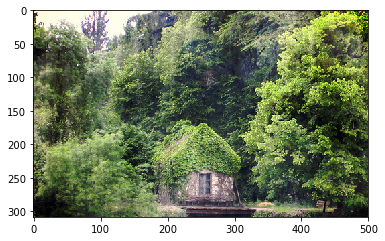

In [66]:
plot_arr(src)

In [76]:
style_layers = [outputs["block{}_conv2".format(o)] for o in range (1,6)]
content_name = "block4_conv2"
content_layer = [outputs[content_name]]# content 使用block4——con2，style使用各层加权

In [77]:
style_model = Model(model.input,style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [78]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [79]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [80]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [81]:
evaluator = Evaluator(transfer_fn, shp)

In [82]:
iterations=10
x = rand_img(shp)

In [83]:
x = solve_image(evaluator, iterations, x)

Current loss value: 7531.42138672
Current loss value: 1808.75268555
Current loss value: 1112.64611816
Current loss value: 809.522216797
Current loss value: 655.30255127
Current loss value: 532.665893555
Current loss value: 452.864746094
Current loss value: 397.438598633
Current loss value: 362.790466309
Current loss value: 338.168945312


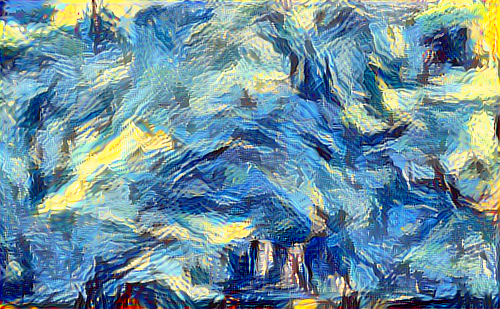

In [86]:
Image.open(path + 'results/res_at_iteration_9.png')